# Weather Forecasting

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import logging
import numpy as np
import pandas as pd
from zipfile import ZipFile
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, RegressorMixin
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS
from xgboost import XGBRegressor

rcParams["figure.figsize"] = 15, 7

sns.set(palette = "Set2", font_scale = 1.3)

In [2]:
compare_table = None

def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    
    global compare_table
    
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast),
        'Median_error': median_absolute_error(y_true,y_forecast),
        'R^2' : r2(y_true,y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

In [6]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

--2023-04-30 22:46:42--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.162.128, 64.233.161.128, 64.233.165.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12,94M  10,5MB/s    in 1,2s    

2023-04-30 22:46:44 (10,5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [7]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев значение каждой величины за сутки:

In [8]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

weather_df_daily = weather_df.set_index("Date").resample('D').max().reset_index()
del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2016-12-28,1015.35,6.29,278.53,3.11,91.9,9.55,7.64,2.19,4.70,7.54,1275.20,4.08,7.45,348.3
2016-12-29,1015.21,4.55,276.65,2.43,98.1,8.46,7.28,1.79,4.47,7.17,1297.30,2.04,2.80,344.8
2016-12-30,1012.55,3.67,276.11,2.97,98.2,7.95,7.56,1.70,4.67,7.49,1312.47,2.20,3.77,282.7
2016-12-31,1008.67,5.21,278.12,-3.04,91.8,8.86,4.88,4.03,3.03,4.86,1314.79,1.49,2.75,333.3
2017-01-01,999.82,-4.82,268.36,-8.42,75.7,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


Разделим данные на обучающие и тестовые. В качестве тестового отрезка времени возьмем данные за последний год. Обратим внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [9]:
insert_df = pd.concat([weather_df_daily.loc['2016-10-25', :], weather_df_daily.loc['2016-10-28', :]], axis = 1, ignore_index = False).transpose()
new_index = ['2016-10-26', '2016-10-27']
insert_df = insert_df.rename(index = dict(zip(insert_df.index, new_index)))

weather_df_daily = pd.concat(
                      [weather_df_daily.loc[weather_df_daily.index < '2016-10-26'],
                      insert_df,
                      weather_df_daily.loc[weather_df_daily.index > '2016-10-27']],
                      axis = 0
)

weather_df_daily.index = pd.to_datetime(weather_df_daily.index)

Выделим целевую переменную - погоду на завтра - в отдельный столбец:

In [10]:
weather_df_daily['Target'] = weather_df_daily['T (degC)'].shift(-1)
weather_df_daily.drop('2017-01-01', axis = 0, inplace = True)

In [11]:
test_size = 366
df_train = weather_df_daily.iloc[ : -test_size]
df_test = weather_df_daily.iloc[-test_size : ]

Визуализируем график температуры с годами:

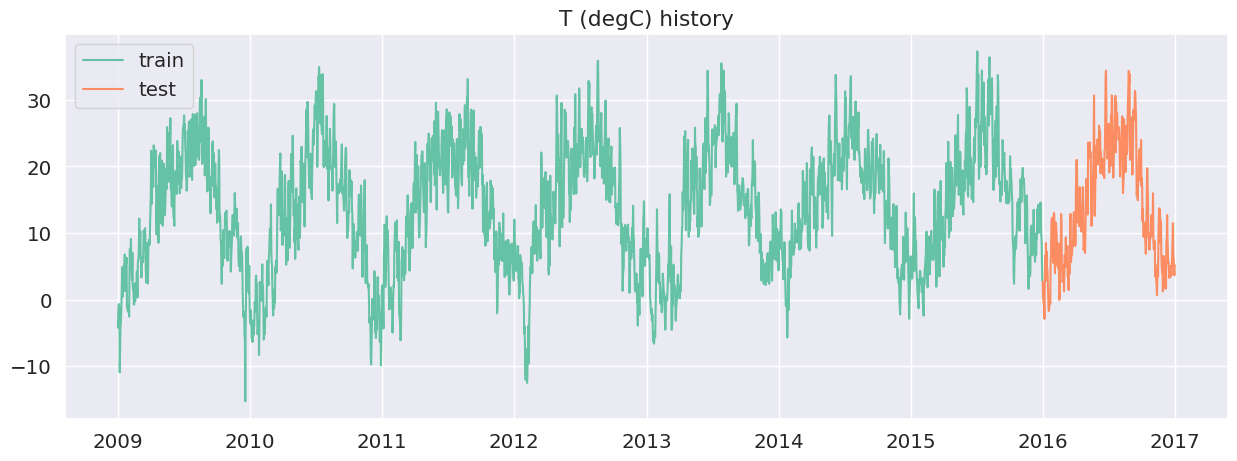

In [12]:
plt.figure(figsize = (15, 5))
plt.title("T (degC) history")
plt.plot(df_train.index, df_train['T (degC)'], label = 'train')
plt.plot(df_test.index, df_test['T (degC)'], label = 'test')
plt.legend();

In [13]:
target_train = df_train[['Target']]
target_test = df_test[['Target']]

Проведем простую аналитику:

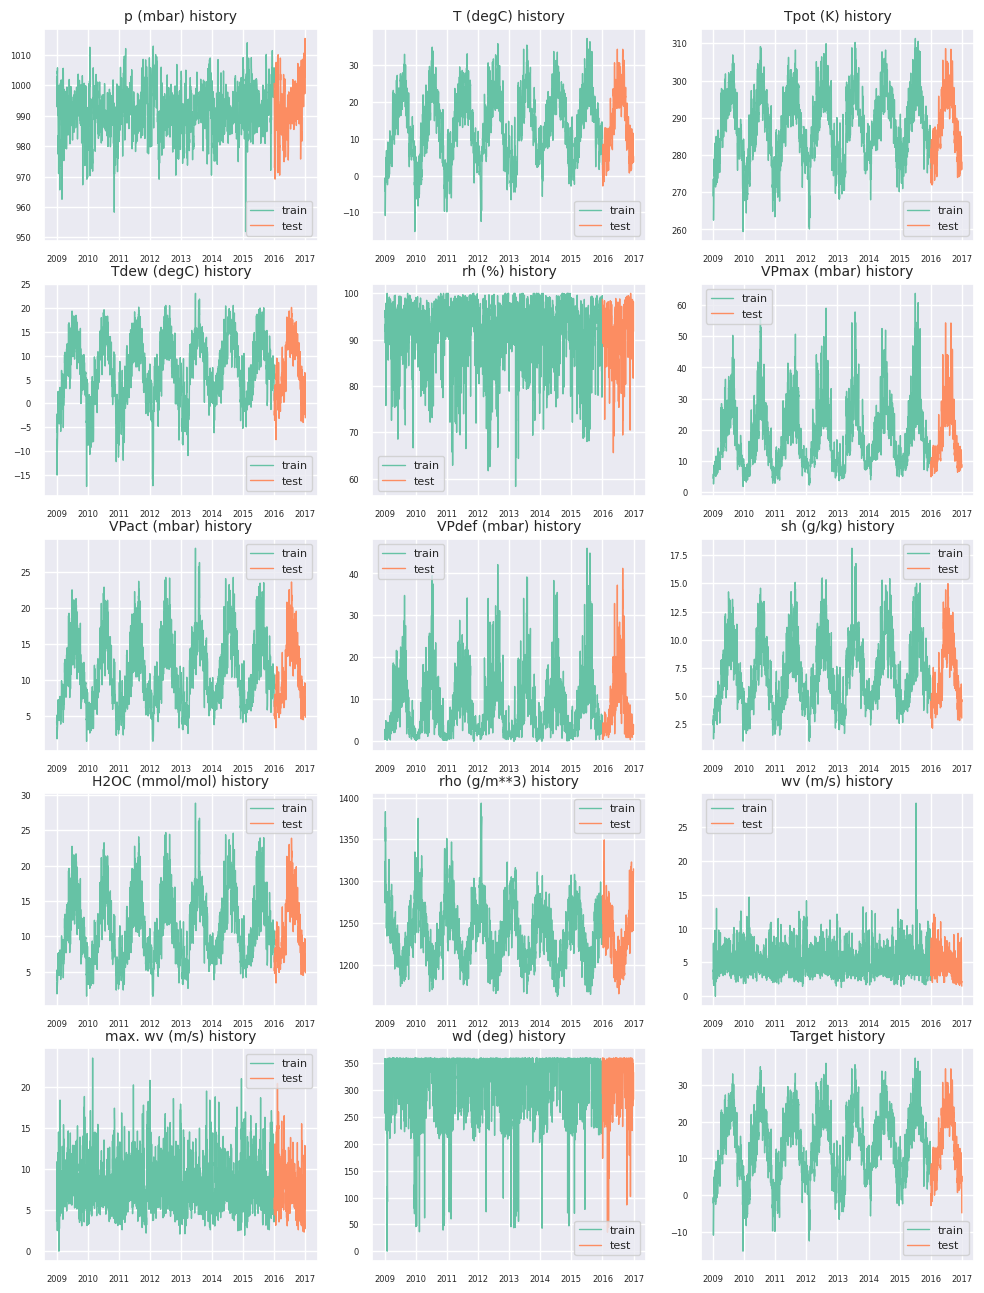

In [18]:
plt.figure(figsize = (12, 16))

for i, col in enumerate(df_train.columns):
    plt.subplot(5, 3, i + 1)
    plt.title(f"{col} history", fontsize = 10)
    plt.plot(df_train.index, df_train[col], label = 'train', lw = 1)
    plt.plot(df_test.index, df_test[col], label = 'test', lw = 1)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 6)
    plt.legend(fontsize = 8)

plt.show()

Видим, что в данных есть немного явных выбросов, разберемся с ними методом межквартильного размаха: *поскольку погода может резко меняться по некоторым паарметрам, то будем брать не 97\% доверительный интервал, а 99\%*:

In [27]:
alpha = 0.01
colums_bounds = dict()

for key in df_train.keys():
    vals = df_train[key].values
    colums_bounds[key] = np.quantile(vals, q = [alpha / 2, 1 - alpha / 2])

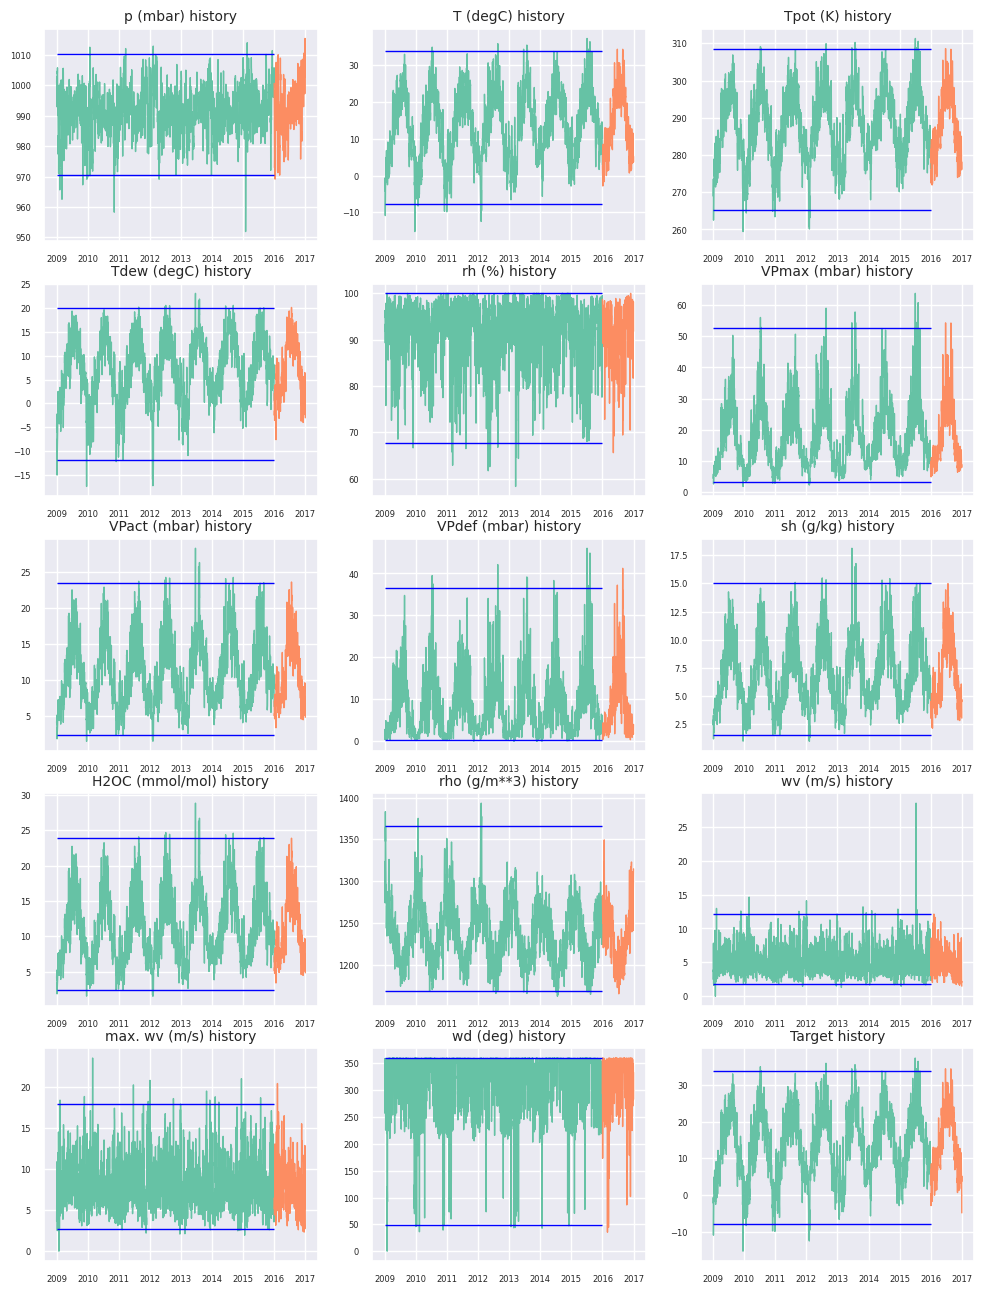

In [28]:
plt.figure(figsize = (12, 16))

for i, col in enumerate(df_train.columns):
    plt.subplot(5, 3, i + 1)
    plt.title(f"{col} history", fontsize = 10)
    plt.plot(df_train.index, df_train[col], label = 'train', lw = 1)
    plt.plot(df_test.index, df_test[col], label = 'test', lw = 1)
    plt.hlines(y=colums_bounds[col][0], xmin=df_train.index[0], xmax=df_train.index[-1], linewidth=2, color='blue', label='Down bound', lw = 1)
    plt.hlines(y=colums_bounds[col][1], xmin=df_train.index[0], xmax=df_train.index[-1], linewidth=2, color='blue', label='Up bound', lw = 1)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 6)

plt.show()

In [29]:
for key in df_train.keys():
    # change train
    vals = df_train[key].values
    up_outlier = (vals > colums_bounds[key][1])
    down_outlier = (vals < colums_bounds[key][0])
    df_train[key][up_outlier] = colums_bounds[key][1]
    df_train[key][down_outlier] = colums_bounds[key][0]

    # change test based on train!
    if key != 'Target':
        vals = df_test[key].values
        up_outlier = (vals > colums_bounds[key][1])
        down_outlier = (vals < colums_bounds[key][0])

        df_test[key][up_outlier] = colums_bounds[key][1]
        df_test[key][down_outlier] = colums_bounds[key][0]

Посчитаем коррелляционную матрицу:

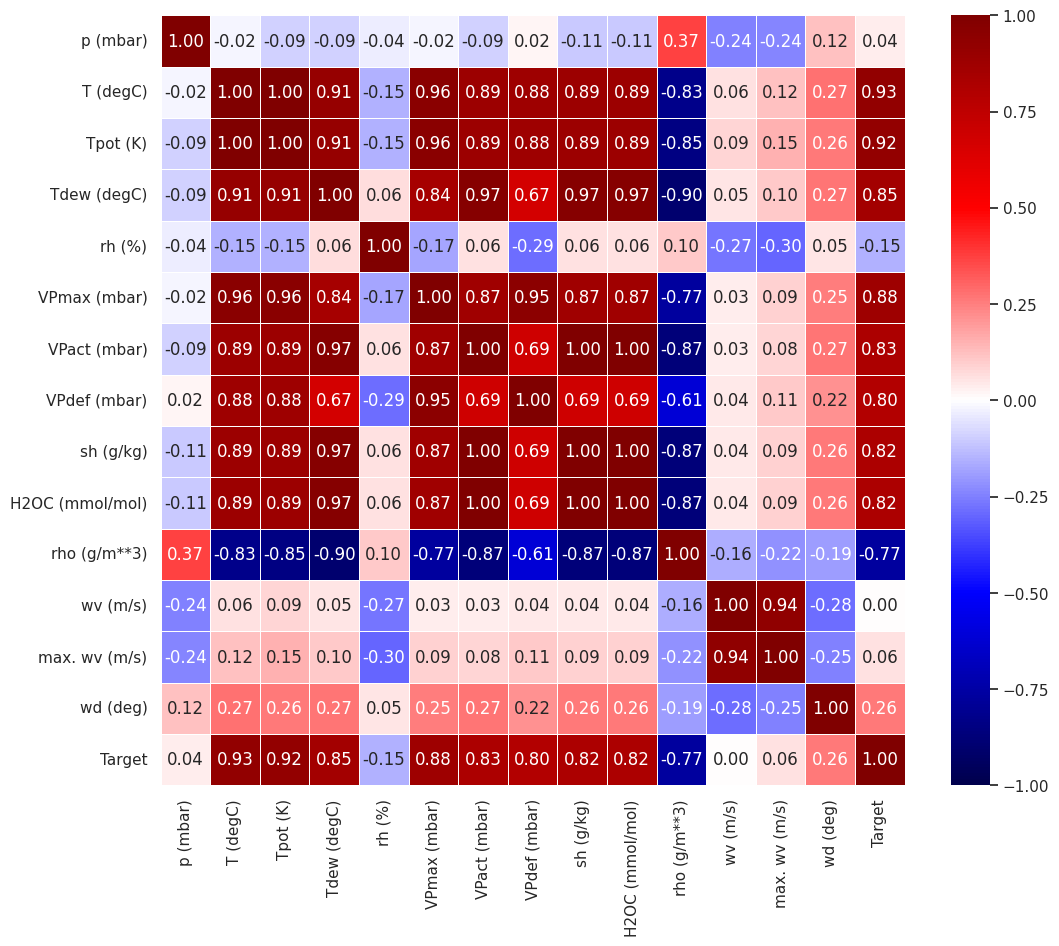

In [34]:
sns.set(rc = {'figure.figsize': (12, 10)})
corr = df_train.corr()
sns.heatmap(corr, linewidth = 0.5, cmap = "seismic", vmin = -1, vmax = 1, fmt = '.2f', annot = True)
plt.show(block = True)

**Вывод** целевой признак очень хорошо кореллирует с h2OC, sh, ..., VPmax, а также с Tdew, Tpot. Но тут проблема в том, что сами эти признаки имеют очень сильную попарную корреляцию. Поэтому все их использовать для предсказания - вредно!

Далее мы попробуем выкидывать по одному эти признаки и смотреть на результат!

Реализуем основные метрики для оченки результатов:

In [35]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    residual = np.sum(np.square(y_true - y_pred))
    total = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - residual / total
    return r2

def print_metrics(y_true, y_pred):
    print(f'MSE : ',  mean_squared_error(y_true, y_pred))
    print(f'MAE : ',  mean_absolute_error(y_true, y_pred))
    print(f'MAPE : ', mean_absolute_percentage_error(y_true, y_pred))
    print(f'MedAE : ', median_absolute_error(y_true, y_pred))
    print(f'R^2 : ', r2(y_true, y_pred))

## Теперь будем создавать фичи и обучать модели!

Из Weather1.0 мы помним, что линейная регрессия дает очень хорошие результаты, что можно добавить немного фичей со скользащим окном в 7 дней:

In [36]:
df_train.drop(columns = ['Target'], inplace = True)
df_test.drop(columns = ['Target'], inplace = True)

In [37]:
window_size = 7
for col in df_train.columns:
    df_train[f'{col}_wmean'] = df_train[col].rolling(window = window_size, min_periods = 1).mean()
    df_train[f'{col}_wmedian'] = df_train[col].rolling(window = window_size, min_periods = 1).median()
    df_train[f'{col}_wmin'] = df_train[col].rolling(window = window_size, min_periods = 1).min()
    df_train[f'{col}_wmax'] = df_train[col].rolling(window = window_size, min_periods = 1).max()

    df_test[f'{col}_wmean'] = df_test[col].rolling(window = window_size, min_periods = 1).mean()
    df_test[f'{col}_wmedian'] = df_test[col].rolling(window = window_size, min_periods = 1).median()
    df_test[f'{col}_wmin'] = df_test[col].rolling(window = window_size, min_periods = 1).min()
    df_test[f'{col}_wmax'] = df_test[col].rolling(window = window_size, min_periods = 1).max()

In [40]:
model = LinearRegression()
model.fit(df_train, target_train)

LinearRegression()

In [42]:
sorted_columns = []

for col, coef in sorted(zip(df_train.columns, model.coef_.squeeze()), key = lambda x: abs(x[1])):
    sorted_columns.append(col)
    print(f'{col} : {coef:5f}')

wd (deg)_wmedian : 0.002395
wd (deg)_wmin : 0.002679
rh (%)_wmedian : 0.003202
wd (deg)_wmean : 0.004033
wd (deg) : -0.005750
rh (%)_wmin : -0.008368
wd (deg)_wmax : 0.008911
rh (%) : -0.011779
rho (g/m**3)_wmin : -0.012430
rho (g/m**3) : -0.015303
rho (g/m**3)_wmedian : -0.016698
p (mbar) : -0.017458
rho (g/m**3)_wmean : 0.018744
rho (g/m**3)_wmax : -0.018857
VPmax (mbar)_wmin : 0.019452
wv (m/s)_wmax : -0.021604
max. wv (m/s)_wmin : -0.022106
VPdef (mbar)_wmax : -0.031433
rh (%)_wmean : 0.042878
VPmax (mbar)_wmax : 0.049888
Tdew (degC)_wmax : 0.071619
max. wv (m/s)_wmax : 0.079825
Tdew (degC)_wmin : -0.082031
rh (%)_wmax : -0.086772
p (mbar)_wmedian : 0.089626
VPdef (mbar)_wmedian : 0.090612
max. wv (m/s)_wmedian : 0.102423
Tdew (degC)_wmedian : 0.106880
p (mbar)_wmin : 0.107715
p (mbar)_wmax : 0.114380
VPmax (mbar)_wmedian : -0.118027
VPmax (mbar) : 0.118439
Tpot (K)_wmin : -0.118759
max. wv (m/s)_wmean : -0.127732
wv (m/s)_wmedian : 0.145696
VPdef (mbar)_wmin : -0.146670
wv (m/s) :

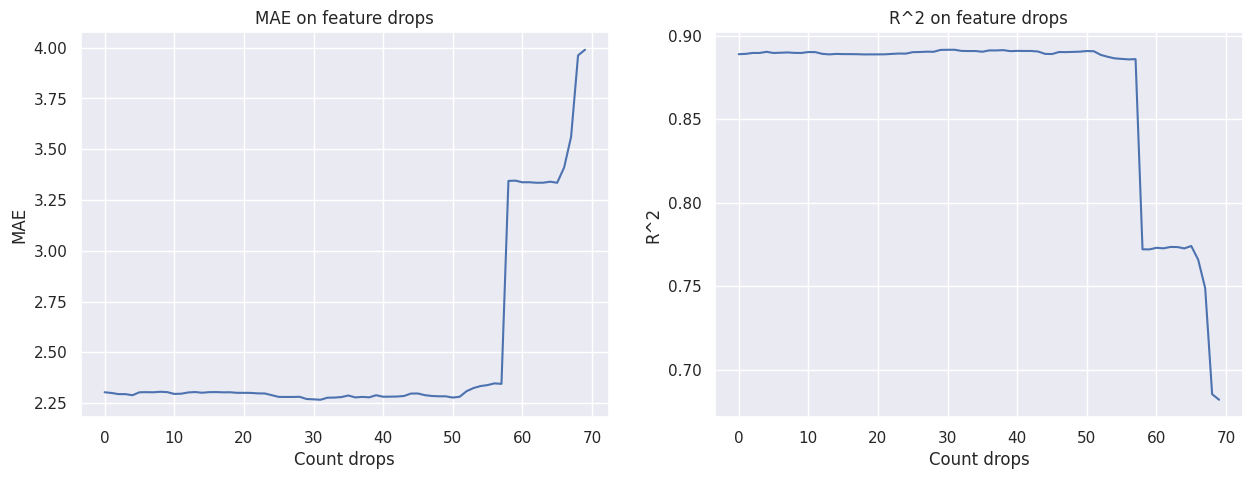

In [43]:
mae_history = []
r2_history = []

for i in range(len(sorted_columns)):
    
    drop_cols = sorted_columns[ :i]
    model = LinearRegression()
    model.fit(df_train.drop(columns = drop_cols), target_train)
    y_pred = model.predict(df_test.drop(columns = drop_cols))
    mae_history.append(mean_absolute_error(target_test.values, y_pred))
    r2_history.append(r2(target_test.values, y_pred))
            

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title('MAE on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), mae_history)
plt.xlabel('Count drops')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.title('R^2 on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), r2_history);
plt.xlabel('Count drops')
plt.ylabel('R^2');

In [44]:
pd.DataFrame({'MAE' : mae_history, 'R^2' : r2_history}).head(35)

,MAE,R^2
0,2.303622,0.888927
1,2.300029,0.889108
2,2.294464,0.889664
3,2.294395,0.889657
4,2.289012,0.890341
5,2.303478,0.889644
6,2.304141,0.889798
7,2.303528,0.889971
8,2.305929,0.889698
9,2.304211,0.889650


Видим, что если выкинем первые 31 фичу, то качество будет наилучшим для такого набора:

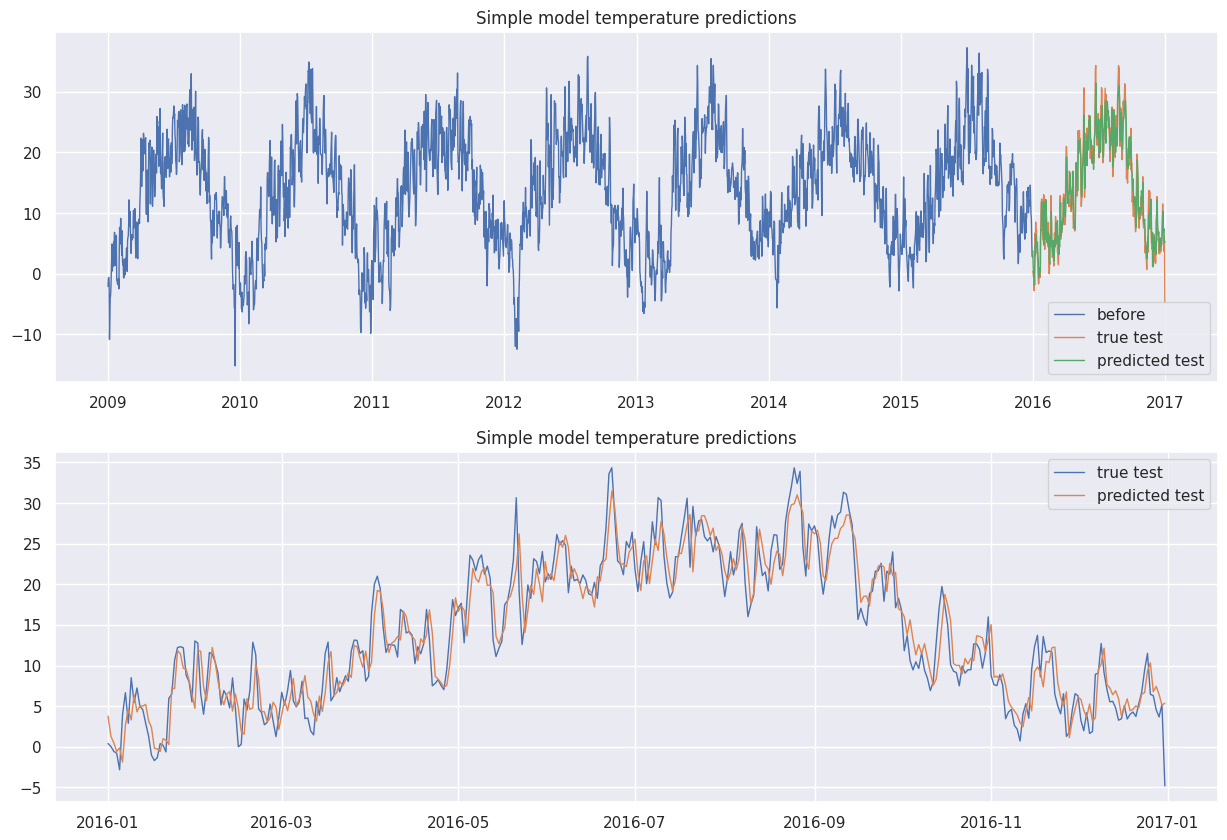

In [45]:
drop_cols = sorted_columns[ :31]
model = LinearRegression()
model.fit(df_train.drop(columns = drop_cols), target_train)
y_pred = model.predict(df_test.drop(columns = drop_cols))

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [46]:
add_results_in_comparison_table('linreg drops best', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,8.392372,2.266731,175.256018,1.972233,0.891577


In [47]:
df_train_1 = df_train.drop(columns = drop_cols)
df_test_1 = df_test.drop(columns = drop_cols)

In [51]:
import scipy.stats as sps

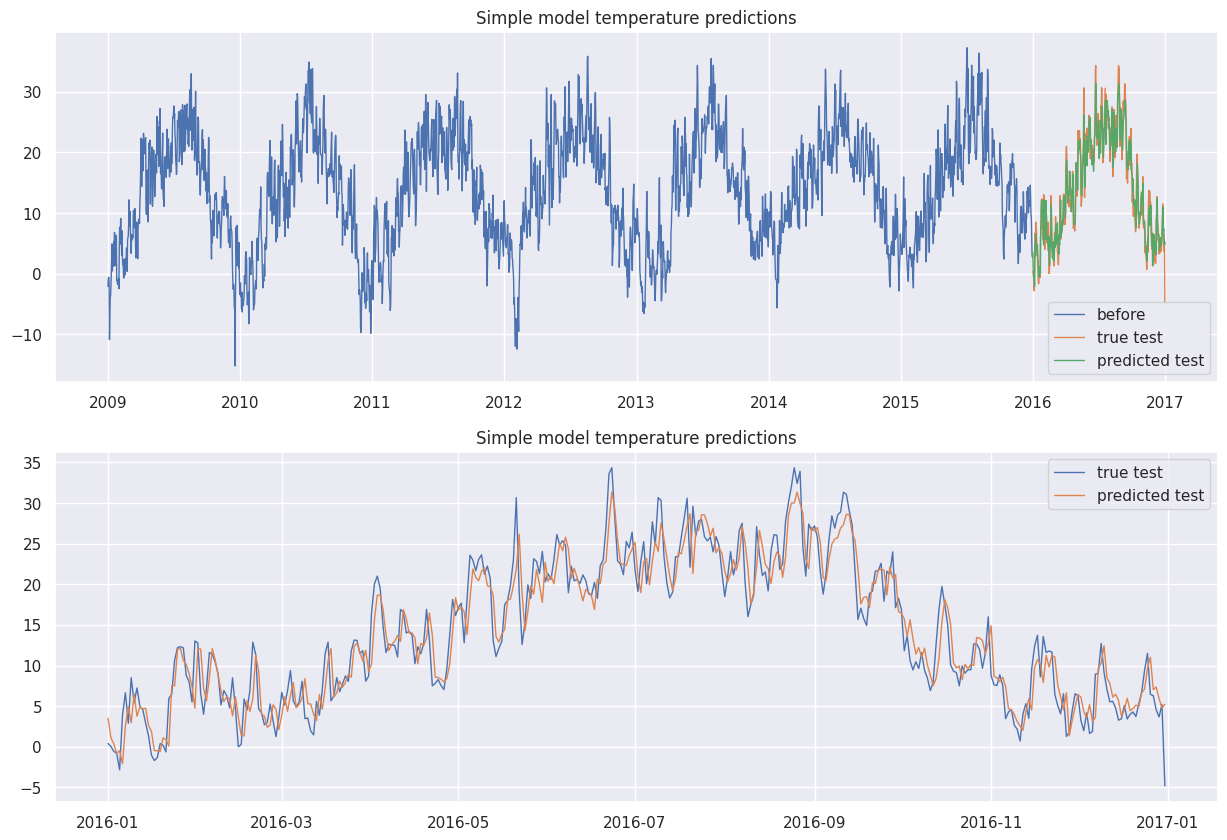

In [52]:
model = LinearRegression()
model.fit(df_train_1, target_train)
y_fit = model.predict(df_train_1)
y_pred = model.predict(df_test_1)

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_1)
X_test = scaler.transform(df_test_1)

X_train_boxcox = np.array([
    sps.boxcox((X_train - X_train.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_train.shape[1])
]).T
X_test_boxcox = np.array([
    sps.boxcox((X_test - X_test.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_test.shape[1])
]).T

model_res = SVR(
    C = 0.5,
    epsilon = 1.2
)
model_res.fit(X_train_boxcox, target_train - y_fit)
y_pred += model_res.predict(X_test_boxcox).reshape(-1, 1)

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [54]:
add_results_in_comparison_table('linreg+SVR on resids', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,8.392372,2.266731,175.256018,1.972233,0.891577
1,linreg+SVR on resids,8.172704,2.233192,142.327969,1.968537,0.894415


**Вывод:** Немного улучшили результат!

Посмотрим как тут распределены остатки:

In [56]:
def get_studentized_residuals(X, y_true, y_pred):
    H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
    rss = ((y_true - y_pred)**2).sum()
    std = rss / (X.shape[0] - X.shape[1] - 1)
    e = (y_true - y_pred) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return e

student_residuals = get_studentized_residuals(df_test_1.to_numpy(), target_test['Target'].to_numpy().squeeze(), y_pred.squeeze())

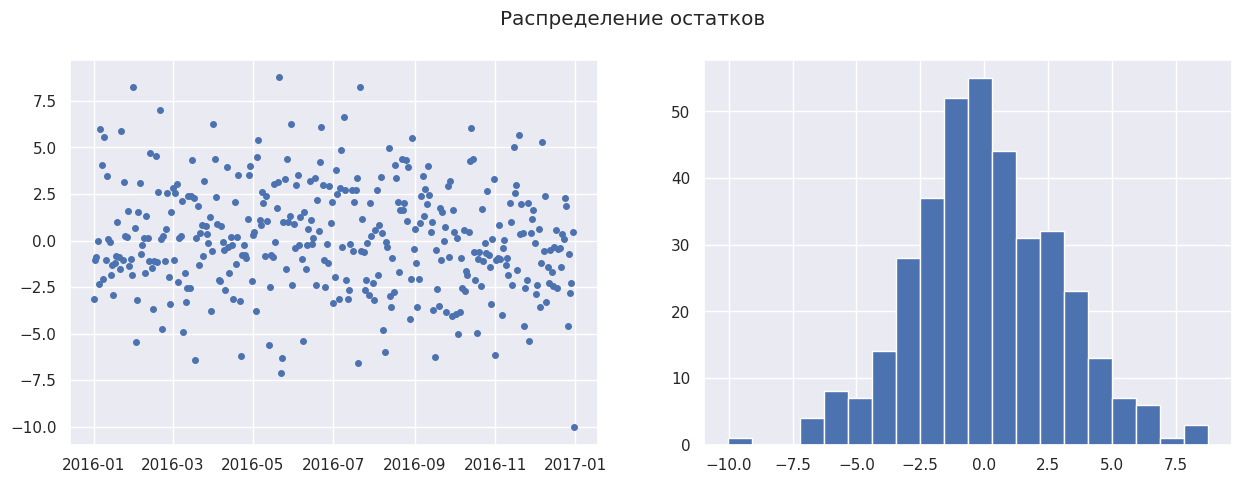

In [59]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(target_test - y_pred, 'o', markersize = 4);
plt.subplot(1, 2, 2)
plt.hist(target_test - y_pred, bins = 20)
plt.suptitle('Распределение остатков')
plt.show();

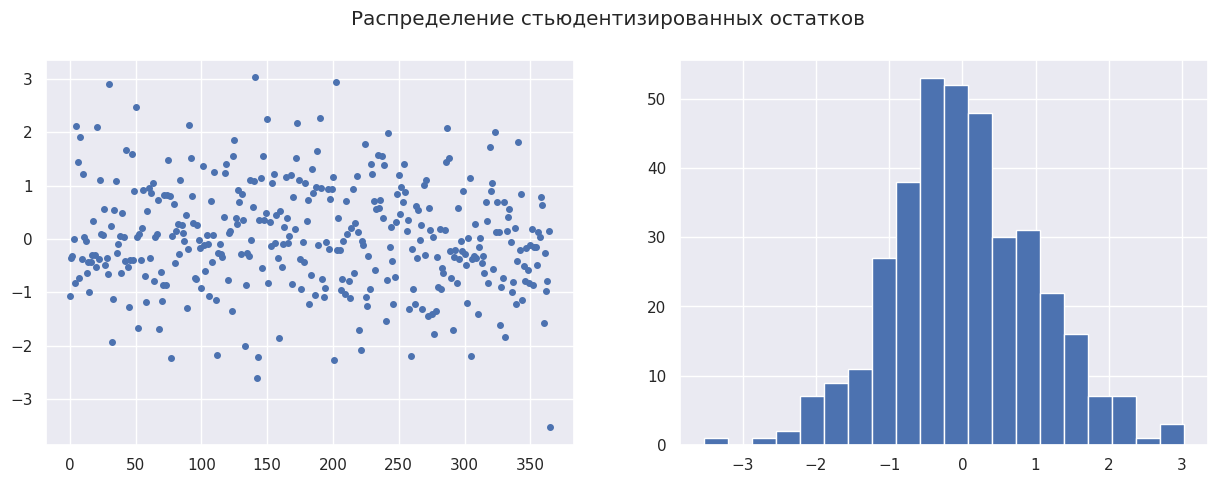

In [60]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(student_residuals, 'o', markersize = 4);
plt.subplot(1, 2, 2)
plt.hist(student_residuals, bins = 20)
plt.suptitle('Распределение стьюдентизированных остатков')
plt.show();

In [61]:
import scipy.stats as sps
sps.normaltest(student_residuals)

NormaltestResult(statistic=2.201777501121903, pvalue=0.3325753757604804)

Принимаем гипотезу о том, что остатки распределены нормально! Также они лежат в диапазоне от -3 до 3, что свидетельствует о хорошем качестве нашей модели!

Попробуем предсказывать не на год вперед, а на 1 день:

In [134]:
big_df = pd.concat([df_train_1, df_test_1], axis = 0)
target = pd.concat([target_train, target_test], axis = 0)

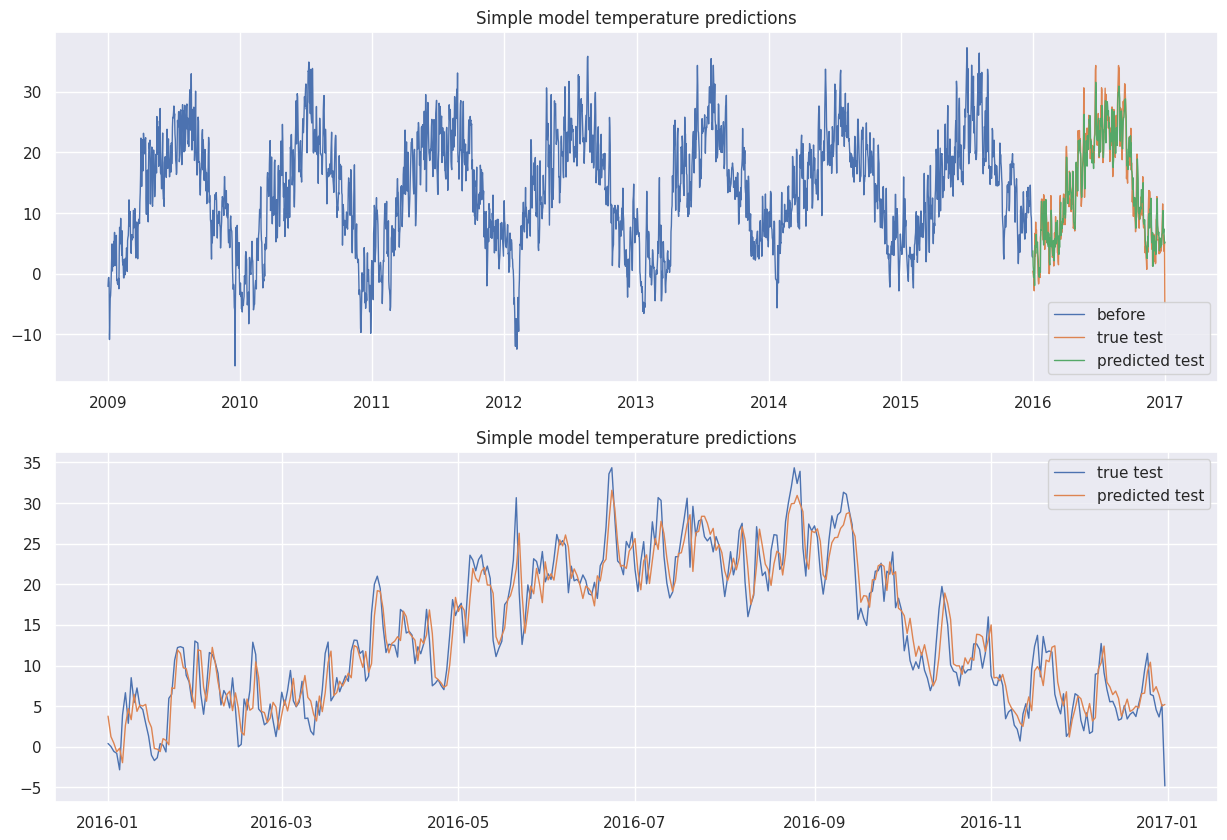

In [135]:
y_pred = []
for i in range(test_size, 0, -1):
    #print(i)
    model = LinearRegression()
    model.fit(big_df[ : -i], target[ : -i])
    if i > 1:
        pred = model.predict(big_df.iloc[ -i : -i + 1])
    else:
        pred = model.predict(big_df.iloc[-1 :])
    y_pred.append(pred)
    
y_pred = np.array(y_pred).squeeze()
plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [136]:
print_metrics(target_test['Target'].values, y_pred)

MSE :  8.40406734027212
MAE :  2.266052716523675
MAPE :  175.9565831317324
MedAE :  1.962118255020492
R^2 :  0.8914254835567759


Видим, что лучше бейзлайна, если бы мы по этим же столбцам предсказывали просто на год вперед! Проверим теперь с предсказанием остатка:

In [144]:
def next_day_predictions_boost(X_train, y_train, X_test):
    model1 = LinearRegression()
    model.fit(X_train, y_train)
    y_fit = model.predict(X_train)
    y_pred = model.predict(X_test)
    model2 = SVR(
        C = 0.5,
        epsilon = 1.2
    )
    model2.fit(X_train, y_train - y_fit)
    y_pred += model2.predict(X_test)
    return y_pred
    
big_df = pd.concat([df_train_1, df_test_1], axis = 0)
target = pd.concat([target_train, target_test], axis = 0)

y_pred = []

for i in range(test_size, 0, -1):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(big_df.iloc[ : -i])
    if i > 1:
        X_test = scaler.transform(big_df.iloc[ -i : -i + 1])
    else:
        X_test = scaler.transform(big_df.iloc[ -1 : ])
    
    y_pred.append(next_day_predictions_boost(X_train, target[ : -i], X_test))

In [150]:
add_results_in_comparison_table('linreg+SVR next day norm', target_test['Target'].values, np.array(y_pred).squeeze())

,method,MSE,MAE,MAPE,Median_error,R^2
0,linreg drops best,8.392372,2.266731,175.256018,1.972233,0.891577
1,linreg+SVR on resids,8.172704,2.233192,142.327969,1.968537,0.894415
2,linreg+SVR next day norm,8.161188,2.239468,143.202867,1.877257,0.894563


Видим, что совсем немного удалось улучшить результат((